In [ ]:
import torch
import torchvision
import numpy as np
import cv2
import argparse
from PIL import Image
from torchvision.transforms import transforms as transforms
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt

#Very hacky fix to make matplotlib work on my pc
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

repo_dir = "c:/Users/James/git/3dGolfPoseDetection/"
videos_dir = repo_dir + "dev-nbs/videos/"
videos_filenames = os.listdir(videos_dir)
print(videos_filenames)

video_filepath = videos_dir + videos_filenames[0]
print(video_filepath)
assert Path(video_filepath).exists(), f"File does not exist!! {video_filepath}"

#download and unzip kaggle data
# !kaggle datasets download -d andrewmvd/3d-golf-swing-dataset
# https://www.kaggle.com/datasets/marcmarais/golfdb-entire-image

golfdb_dir = repo_dir + "downloaded-data/golfdb/Swing_events/"
golfdb_foldernames = os.listdir(golfdb_dir)
folder_path = golfdb_dir + golfdb_foldernames[0] + "/"
image_paths = [folder_path + x for x in os.listdir(folder_path)]
print(len(image_paths), image_paths[:5])
img = cv2.imread(image_paths[0])
Image.fromarray(img[:,:,::-1])

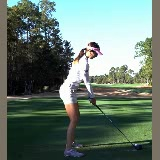

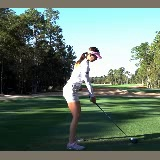

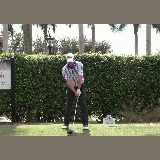

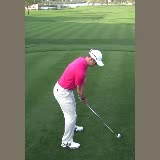

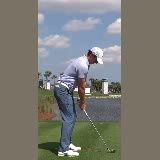

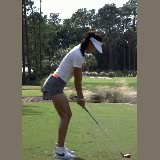

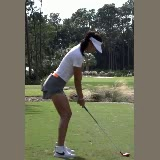

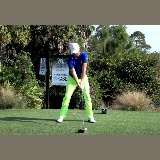

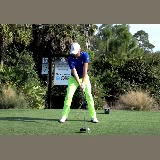

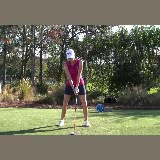

In [5]:
for i in range(0, 10):
    img = cv2.imread(image_paths[i])
    display(Image.fromarray(img[:,:,::-1]))

In [6]:
image_paths = image_paths[:10]

rescale_height = 800

img_num = 1
while image_paths:
    #really images will be filename and file will be loaded in first name
    # img = cv2.imread(filename)
    img = cv2.imread(image_paths[-1])

    #### Rescale image
    h, w = img.shape[:2]
    r = rescale_height / float(h)
    dim = (int(w * r), rescale_height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    ### Labelled images in window
    golf_club_coordinates = []

    skip = False
    def click_event_label(event, x, y, flags, params):
        # checking for left mouse clicks or right mouse clicks
        if event==cv2.EVENT_RBUTTONDOWN:
            global skip
            skip = True
        if event == cv2.EVENT_LBUTTONDOWN:
            global golf_club_coordinates
            golf_club_coordinates.append([int(x),int(y)])

        
    img_name = f'image_{img_num}'
    cv2.imshow(img_name, resized)
    cv2.setWindowProperty(img_name, cv2.WND_PROP_TOPMOST, 1)
    cv2.setMouseCallback(img_name, click_event_label)
    while len(golf_club_coordinates) != 2:
        if skip:
            break
        cv2.waitKey(100)
    if skip:
        image_paths = image_paths[:-1]
        cv2.destroyWindow(img_name) #make sure window closes cleanly
        continue

    cv2.destroyWindow(img_name) #make sure window closes cleanly

    ### Annotate labels on images
    labelled = resized.copy()
    grip = golf_club_coordinates[0]
    club = golf_club_coordinates[1]
    cv2.circle(labelled, grip, 5, (255,0,255), -1)
    cv2.circle(labelled, club, 5, (255,0,255), -1)
    cv2.line(labelled, club, grip, (255, 0, 0), 2)

    
    save = False
    redo = False
    def click_event_decide(event, x, y, flags, params):
        # checking for left mouse clicks or right mouse clicks
        if event == cv2.EVENT_LBUTTONDOWN:
            global save
            save = True
        elif event == cv2.EVENT_RBUTTONDOWN:
            global redo
            redo = True

    img_name_labelled = f'image_{img_num}_labelled'
    cv2.imshow(img_name_labelled, labelled)
    cv2.setWindowProperty(img_name_labelled, cv2.WND_PROP_TOPMOST, 1)
    cv2.setMouseCallback(img_name_labelled, click_event_decide)

    while not (save or redo):
        cv2.waitKey(100)
    cv2.destroyWindow(img_name_labelled) #make sure window closes cleanly
    
    if save:
        print("saving...")
        save_dir = repo_dir + "/dev-nbs/saved-labels/"
        save_path = save_dir + f"{img_num}.png"
        cv2.imwrite(save_path, labelled)
        #golf_club_coordinates
        img_num+=1
        image_paths = image_paths[:-1]
    else:
        print("redoing...")

saving...
